### Predict 2022 Jan COVID-19 Cases given 2020 June to 2021 Dec Data

Mean Absolute Error: 408.2217699115044
Mean Squared Error: 530263.7761663717
Root Mean Squared Error: 728.1921286078089


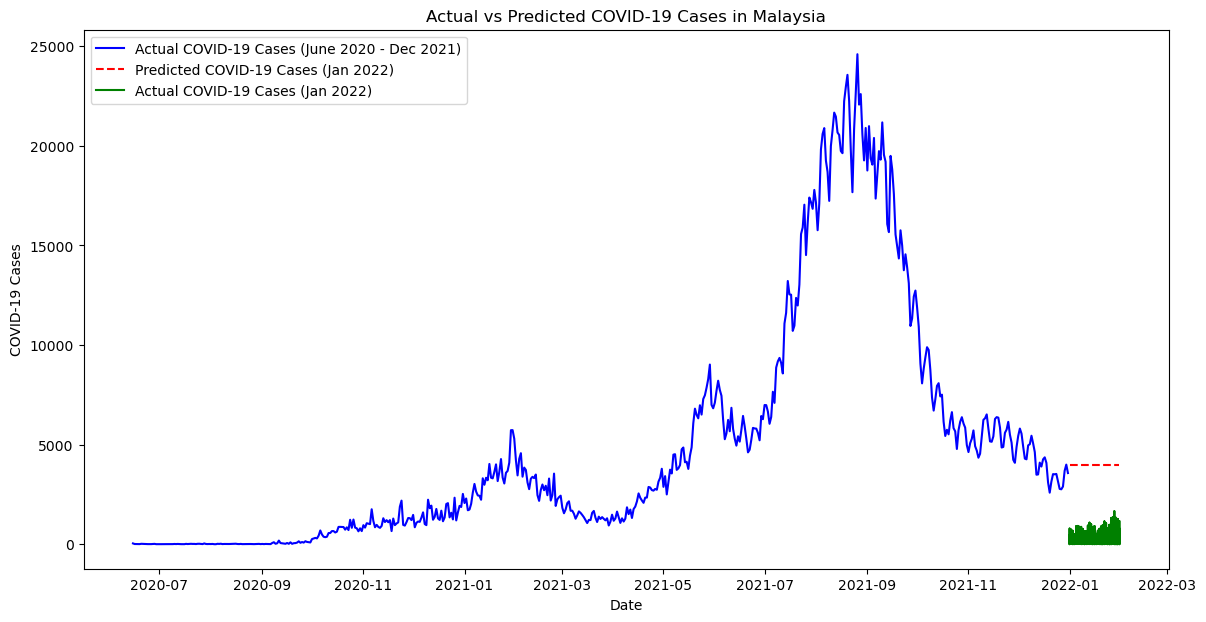

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load the data
covid_data = pd.read_csv('filtered_datasets/cases_state.csv', parse_dates=['date'])

# Aggregate the data by date to get the total cases for Malaysia
covid_data_agg = covid_data.groupby('date').sum().reset_index()

# Filter data for the period from June 2020 to Dec 2021
data = covid_data_agg[(covid_data_agg['date'] >= '2020-06-01') & (covid_data_agg['date'] <= '2021-12-31')]

# Sort the data by date
data = data.sort_values(by='date')

# Create lag features
def create_lag_features(data, lag=14):
    for i in range(1, lag + 1):
        data[f'cases_new_lag_{i}'] = data['cases_new'].shift(i)
    return data

# Apply the function to create lag features
data = create_lag_features(data)

# Drop rows with missing values (due to lagging)
data = data.dropna()

# Select the features and target
features = [col for col in data.columns if 'lag' in col]
target = 'cases_new'

# Split the data into training and testing sets
X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the random forest regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

# Predicting COVID-19 cases for Jan 2022
# Create a DataFrame for June to December 2023 dates
future_dates = pd.date_range(start='2022-01-01', end='2022-1-31', freq='D')
future_data = pd.DataFrame({'date': future_dates})

# Initialize lag features with NaN
for lag in range(1, 15):
    future_data[f'cases_new_lag_{lag}'] = np.nan

# Fill in the lag features with the most recent data from May 2023
for lag in range(1, 15):
    future_data[f'cases_new_lag_{lag}'] = data['cases_new'].iloc[-lag]

# Predict the COVID-19 cases for June to December 2023
future_features = future_data[features]
future_features_scaled = scaler.transform(future_features)

future_data['cases_new_pred'] = model.predict(future_features_scaled)

# Load the actual data for 2022 Jan
actual_future_data = pd.read_csv('filtered_datasets/cases_state.csv', parse_dates=['date'])
actual_future_data = actual_future_data[(actual_future_data['date'] >= '2022-01-01') & (actual_future_data['date'] <= '2022-01-31')]

# Combine historical, predicted, and actual future data
combined_data = pd.concat([data[['date', 'cases_new']], future_data[['date', 'cases_new_pred']], actual_future_data[['date', 'cases_new']]], axis=0)

# Plot the actual and predicted COVID-19 cases
plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['cases_new'], label='Actual COVID-19 Cases (June 2020 - Dec 2021)', color='blue')
plt.plot(future_data['date'], future_data['cases_new_pred'], label='Predicted COVID-19 Cases (Jan 2022)', color='red', linestyle='dashed')
plt.plot(actual_future_data['date'], actual_future_data['cases_new'], label='Actual COVID-19 Cases (Jan 2022)', color='green')
plt.xlabel('Date')
plt.ylabel('COVID-19 Cases')
plt.title('Actual vs Predicted COVID-19 Cases in Malaysia')
plt.legend()
plt.show()
